# Import Libraries

In [352]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [353]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Request Data from the past 12 months from YF

In [354]:
# History(): get historicals for one Stock
# stock = yf.Ticker('TSLA')
# stock_historical = Stock.history(
#     period="5mo", 
#     interval="1d",
# )

# Download(): get historicals for multiple Stocks
# In this case, I just need one for demo
stock_list = ['GOOGL']
stock_historical = yf.download(
    stock_list, 
    period="12mo",
    interval="1d"
)

display(stock_historical.head())
print(len(stock_historical), "data points.")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-06,136.042007,136.472504,135.210007,135.738495,135.738495,20488000
2021-08-09,135.942505,137.184006,135.339493,136.912994,136.912994,17760000
2021-08-10,137.341995,137.772507,136.364502,136.807007,136.807007,19414000
2021-08-11,137.181503,137.682495,136.271500,136.279007,136.279007,15352000
2021-08-12,135.975494,137.300003,135.425507,137.194000,137.194000,16506000


252 data points.


In [355]:
# Save to local
stock_historical.to_csv("./stock_historicals.csv") # not necessary this case

# Calculate EMAs
> - 5-Day for short-term (ST_EMA)
> - 10-Day for long-term (LT_EMA)
>
> 
> $$EMA_{Today} = Close_{Today} \cdot Multiplier + EMA_{yesterday} \cdot (1-Multiplier)$$ <br>
> $$Multiplier = \frac{Smoothing}{1 + Days}$$

,Date,Close,ST_EMA,LT_EMA
0,2021-08-06,135.738495,135.738495,135.738495
1,2021-08-09,136.912994,136.129995,135.952040
2,2021-08-10,136.807007,136.355665,136.107489
3,2021-08-11,136.279007,136.330113,136.138674
4,2021-08-12,137.194000,136.618075,136.330551


<AxesSubplot:xlabel='Date'>

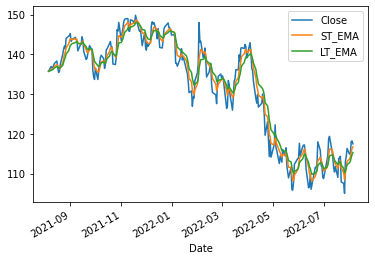

In [356]:
# MACD df with only date and close
MACD_df = stock_historical[["Close"]]
MACD_df.reset_index(inplace=True)
MACD_df.head()

# initial EMA (close price)
init_EMA = MACD_df.Close[0]
smoothing = 2

######################################################################################

# short term EMA (12-days EMA)
ST_period = 5
ST_multiplier = smoothing / (1 + ST_period)
ST_EMA = [init_EMA]

for i in range(1, len(MACD_df['Close'])):
    # Close price is at column 1
    ST_EMA.append( MACD_df.iloc[i,1]*ST_multiplier + ST_EMA[i-1]*(1-ST_multiplier) )

#MACD_df.insert(loc=2, column='ST_EMA', value=pd.Series(ST_EMA))
MACD_df['ST_EMA'] = ST_EMA

######################################################################################

# long term EMA (12-days EMA)
LT_period = 10
LT_multiplier = smoothing / (1 + LT_period)
LT_EMA = [init_EMA]

for i in range(1, len(MACD_df['Close'])):
    # Close price is at column 1
    LT_EMA.append( MACD_df.iloc[i,1]*LT_multiplier + LT_EMA[i-1]*(1-LT_multiplier) )

#MACD_df.insert(loc=2, column='LT_EMA', value=pd.Series(LT_EMA))
MACD_df['LT_EMA'] = LT_EMA

######################################################################################

# df check
display(MACD_df.head())

# plot check
MACD_df.set_index('Date', inplace=True)
MACD_df.plot()

# Calculate MACD, Signal line, and Histogram values
> - **DIF/MACD** is ***ST_EMA - LT_EMA***
> - **DEA/Signal** line is a ***9-day EMA of the DEA/MACD***
> - **Histogram** values is ***DIF - DEA***

In [357]:
MACD_df.reset_index(inplace=True)
# MACD
MACD_df['DIF'] = MACD_df['ST_EMA'] - MACD_df['LT_EMA']

################################################################################
# Signal line
Signal_period = 5
Signal_multiplier = smoothing / (1 + Signal_period)
Signal = [0] #The initial EMA for MACD is considered 0 here

for i in range(1, len(MACD_df['Close'])):
    # MACD is at column 4
    Signal.append( MACD_df.iloc[i,4]*Signal_multiplier + Signal[i-1]*(1-Signal_multiplier) )

MACD_df['DEA'] = Signal

################################################################################
# Histogram
MACD_df['MACD'] = (MACD_df['DIF'] - MACD_df['DEA'])

# df check
MACD_df.set_index('Date', inplace=True)
MACD_df.head()

,Close,ST_EMA,LT_EMA,DIF,DEA,MACD
Date,,,,,,
2021-08-06,135.738495,135.738495,135.738495,0.000000,0.000000,0.000000
2021-08-09,136.912994,136.129995,135.952040,0.177954,0.059318,0.118636
2021-08-10,136.807007,136.355665,136.107489,0.248177,0.122271,0.125906
2021-08-11,136.279007,136.330113,136.138674,0.191439,0.145327,0.046112
2021-08-12,137.194000,136.618075,136.330551,0.287524,0.192726,0.094798


# Plot

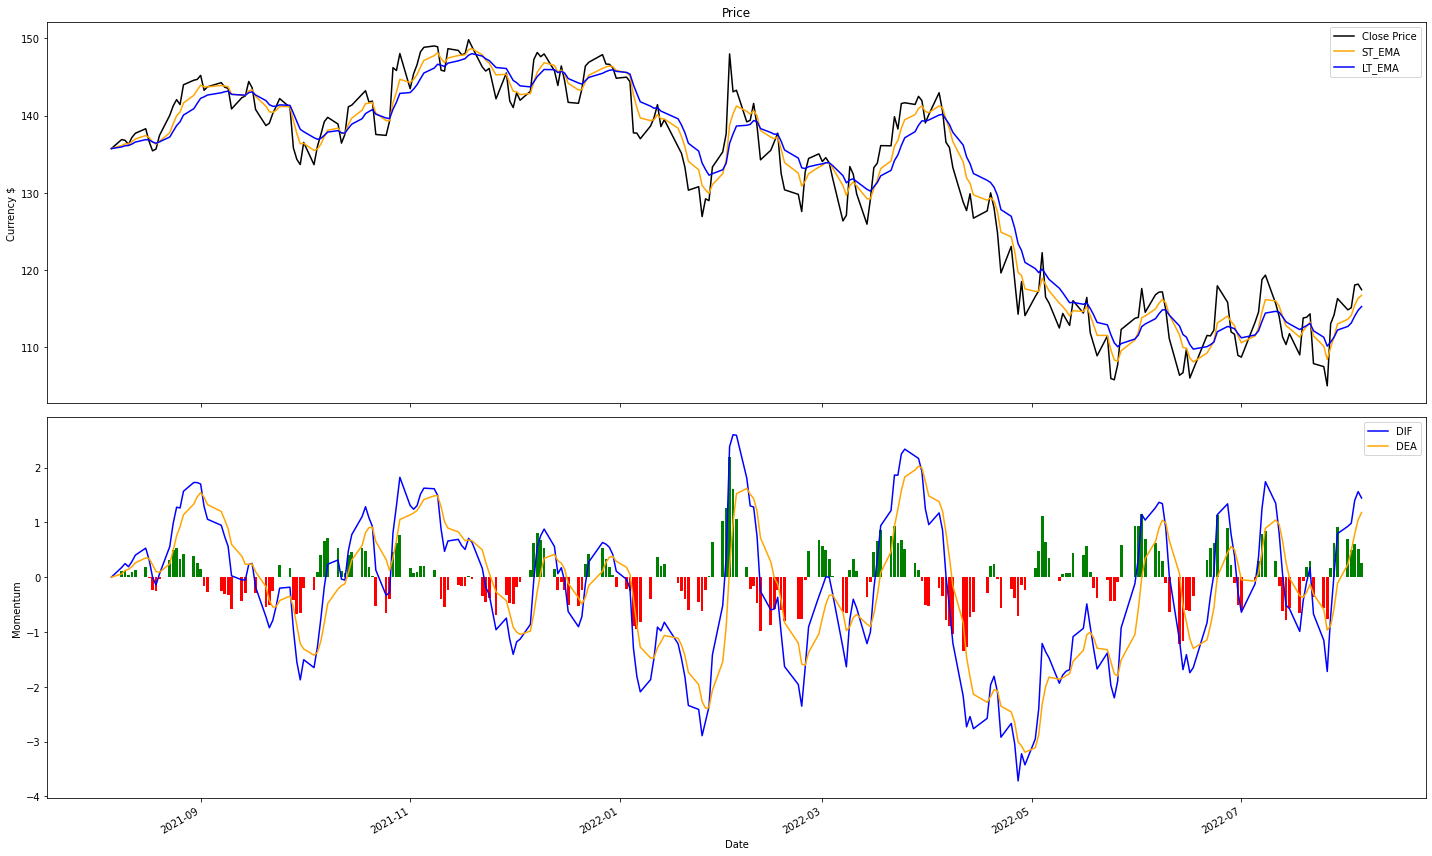

In [358]:
# 2row-1col graph with 
#    Price, ST/LT EMA at top 
#    and MACD, Signal, Hist at bottom
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(20, 12)

ax1.plot(MACD_df.index, MACD_df.Close, color='black', label='Close Price')
ax1.plot(MACD_df.index, MACD_df.ST_EMA, color='orange', label='ST_EMA')
ax1.plot(MACD_df.index, MACD_df.LT_EMA, color='blue', label='LT_EMA')

ax2.plot(MACD_df.index, MACD_df.DIF, color='blue', label='DIF')
ax2.plot(MACD_df.index, MACD_df.DEA, color='orange', label='DEA')
MACD_df['positive'] = MACD_df['MACD'] > 0 # dummy column to separate colors
ax2.bar(MACD_df.index, MACD_df.MACD, color=MACD_df.positive.map({True: 'green', False: 'red'}))

ax1.legend()
ax1.set_title('Price')
ax1.set_ylabel('Currency $')

ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Momentum')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()
fig.savefig('MACD.png')

# Test Trading Strategies

In [359]:
MACD_df.head()

,Close,ST_EMA,LT_EMA,DIF,DEA,MACD,positive
Date,,,,,,,
2021-08-06,135.738495,135.738495,135.738495,0.000000,0.000000,0.000000,False
2021-08-09,136.912994,136.129995,135.952040,0.177954,0.059318,0.118636,True
2021-08-10,136.807007,136.355665,136.107489,0.248177,0.122271,0.125906,True
2021-08-11,136.279007,136.330113,136.138674,0.191439,0.145327,0.046112,True
2021-08-12,137.194000,136.618075,136.330551,0.287524,0.192726,0.094798,True


## 1. Strategy - Old School 
> - Buy on Golden Cross Bullish: *DIF > 0; MACD > 0*
> - Sell on Death Cross Bearish: *DIF < 0; MACD < 0*
> - All-in trading starting with 1 million ($1,000,000)

In [360]:
test_1 = MACD_df.copy()
test_1.reset_index(inplace=True)
test_1['BuySell'] = np.nan
test_1.head()

,Date,Close,ST_EMA,LT_EMA,DIF,DEA,MACD,positive,BuySell
0,2021-08-06,135.738495,135.738495,135.738495,0.000000,0.000000,0.000000,False,NaN
1,2021-08-09,136.912994,136.129995,135.952040,0.177954,0.059318,0.118636,True,NaN
2,2021-08-10,136.807007,136.355665,136.107489,0.248177,0.122271,0.125906,True,NaN
3,2021-08-11,136.279007,136.330113,136.138674,0.191439,0.145327,0.046112,True,NaN
4,2021-08-12,137.194000,136.618075,136.330551,0.287524,0.192726,0.094798,True,NaN


Num of Trades: 14
Ending fund: 712955.29
Gain&Loss: -28.7%


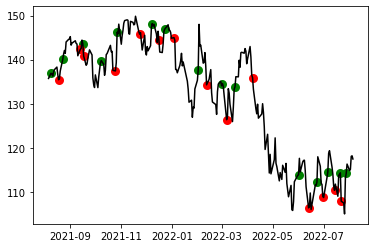

In [361]:
fund_1 = 1000000
shares_bought_1 = 0 # in shares
buy_status_1 = False

for i in range(1, len(test_1['DIF'])):
    # DIF at col 4, MACD at col 6, Close Price at col 1, Date at col 0
    # buy on golden cross bullish
    if test_1.iloc[i,4] > 0 and test_1.iloc[i,6] > 0 and buy_status_1 == False:
        shares_bought_1 += fund_1 // test_1.iloc[i,1]
        fund_1 -= shares_bought_1 * test_1.iloc[i,1]
        test_1.iloc[i,-1] = 'Buy'
        buy_status_1 = True
    # sell on death cross bearish
    elif test_1.iloc[i,4] < 0 and test_1.iloc[i,6] < 0 and buy_status_1 == True:
        fund_1 += shares_bought_1 * test_1.iloc[i,1]
        test_1.iloc[i,-1] = 'Sell'
        shares_bought_1 = 0
        buy_status_1 = False
        
# In case ends with bought shares, reverse the last buy trade
if buy_status_1:
    ending_fund_1 = fund_1 + shares_bought_1 * test_1.loc[test_1.BuySell == 'Buy'].iloc[-1,1]
else:
    ending_fund_1 = fund_1

gain_loss_1 = (ending_fund_1-1000000) / 1000000

# Check Results
print(f'Num of Trades: {min(test_1.BuySell.value_counts()[0],test_1.BuySell.value_counts()[1])}')
print(f'Ending fund: {ending_fund_1.round(2)}')
print(f'Gain&Loss: {(gain_loss_1 * 100).round(2)}%')
plt.plot(test_1.Date, test_1.Close, color='black')
plt.scatter(test_1.Date[test_1.BuySell == 'Buy'], test_1.Close[test_1.BuySell == 'Buy'], color='green', linewidth=3)
plt.scatter(test_1.Date[test_1.BuySell == 'Sell'], test_1.Close[test_1.BuySell == 'Sell'], color='red', linewidth=3)
plt.show()

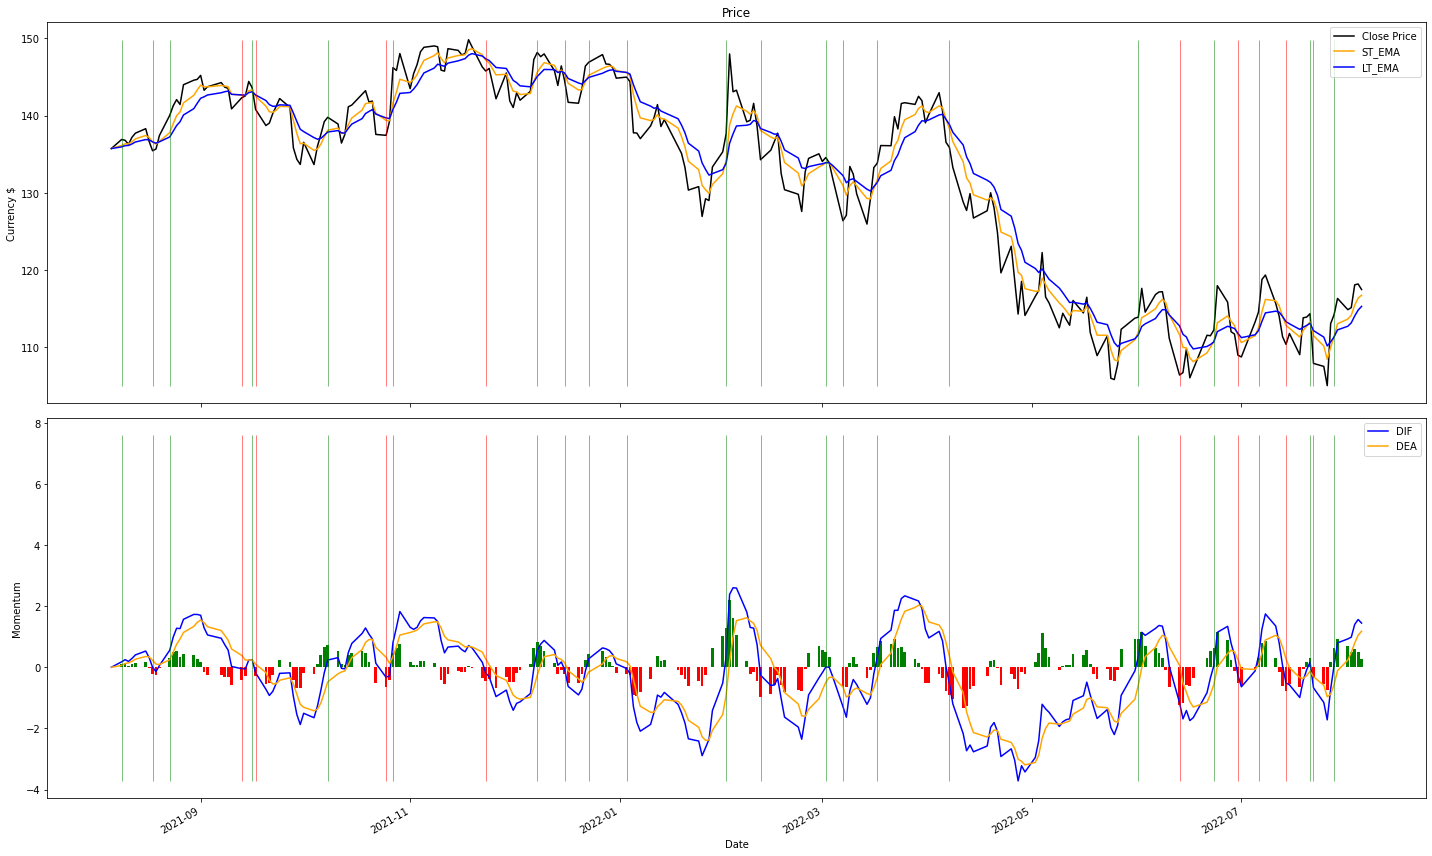

In [362]:
# Detailed Plot
# 2row-1col graph with 
#    Price, ST/LT EMA at top 
#    and MACD, Signal, Hist at bottom
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(20, 12)

ax1.plot(test_1.Date, test_1.Close, color='black', label='Close Price')
ax1.plot(test_1.Date, test_1.ST_EMA, color='orange', label='ST_EMA')
ax1.plot(test_1.Date, test_1.LT_EMA, color='blue', label='LT_EMA')
ax1.vlines(test_1.Date[test_1.BuySell == 'Buy'], ymin=min(test_1.Close), ymax=max(test_1.Close), color='green',linewidth=0.5)
ax1.vlines(test_1.Date[test_1.BuySell == 'Sell'], ymin=min(test_1.Close), ymax=max(test_1.Close), color='red',linewidth=0.5)

ax2.plot(test_1.Date, test_1.DIF, color='blue', label='DIF')
ax2.plot(test_1.Date, test_1.DEA, color='orange', label='DEA')
ax2.vlines(test_1.Date[test_1.BuySell == 'Buy'], ymin=min(test_1.DIF), ymax=max(test_1.DIF)+5, color='green',linewidth=0.5)
ax2.vlines(test_1.Date[test_1.BuySell == 'Sell'], ymin=min(test_1.DIF), ymax=max(test_1.DIF)+5, color='red',linewidth=0.5)
test_1['positive'] = test_1['MACD'] > 0 # dummy column to separate colors
ax2.bar(test_1.Date, test_1.MACD, color=test_1.positive.map({True: 'green', False: 'red'}))

ax1.legend()
ax1.set_title('Price')
ax1.set_ylabel('Currency $')

ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Momentum')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()
fig.savefig('Strategy1.png')

### Results
- TSLA: 8 trades, 22.41%
- MSFT: 13 trades, -22.03%
- COIN: 10 trades, -43.19%
- BA: 9 trades, -27.45%
- GOOGL: 14 trades, -28.7%

### Analysis
- This sucks ass.